In [ ]:
## TRAINING  and TEST SET :  miRNA DATA , MODEL: linear SVM

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

#np.random.seed(7)

# Data Preprocessing

In [2]:
df = pd.read_csv("DS/miRNA_DS_preprocessed_data.csv")

In [3]:
df=(df)

In [4]:
df.shape

(230, 239)

In [5]:
#df = df.drop(df.columns[:14], axis=1)

In [6]:
df = df.T

In [7]:
#Transform the input data
df.rename(columns=df.iloc[0], inplace = True)
df.drop(df.index[0], inplace = True)
df=df.reset_index()

In [8]:
metadata = pd.read_csv("DS/miRNA_DS_metadata_col_info.csv")

In [9]:
df= df.merge(metadata, left_on="index", right_on= "Unnamed: 0")

In [10]:
df['title0'] = df['title0'].replace('(?i)mucosa|normal|healthy', 0, regex=True)


In [11]:
df['title0'] = df['title0'].replace('(?i)Tumor|Cancer|carcinoma', 1, regex=True)

In [12]:
df = df[pd.to_numeric(df['title0'], errors='coerce').notnull()]#remove all non-numeric data from the column.

In [13]:
df= df.drop(['index', 'Unnamed: 0'], axis=1)

In [14]:
df= df.rename(columns={"title0": "index"})

In [15]:
df['index'].value_counts()

index
1    119
0    119
Name: count, dtype: int64

In [16]:
df= df.apply(pd.to_numeric)

In [17]:
X=df.drop("index",axis=1)
y=df['index']

In [18]:
y=y.astype('int')

# Test train split

In [19]:
# split data into training and testing data-sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7)

In [20]:
y_test.value_counts(),y_train.value_counts()

(index
 1    61
 0    58
 Name: count, dtype: int64,
 index
 0    61
 1    58
 Name: count, dtype: int64)

# Cross validation

In [21]:
from sklearn.svm import SVC
# we can add class_weight='balanced' to add panalize mistake
svm_model = SVC(kernel = "linear", probability=True,random_state=47)

# Defining parameter range
param_grid = {
    'C': [0.0005,0.0001,0.001,0.1]
}

grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=3)
# Fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..........................C=0.0005;, score=1.000 total time=   0.0s
[CV 2/5] END ..........................C=0.0005;, score=1.000 total time=   0.0s
[CV 3/5] END ..........................C=0.0005;, score=0.958 total time=   0.0s
[CV 4/5] END ..........................C=0.0005;, score=1.000 total time=   0.0s
[CV 5/5] END ..........................C=0.0005;, score=0.913 total time=   0.0s
[CV 1/5] END ..........................C=0.0001;, score=0.917 total time=   0.0s
[CV 2/5] END ..........................C=0.0001;, score=0.833 total time=   0.0s
[CV 3/5] END ..........................C=0.0001;, score=0.875 total time=   0.0s
[CV 4/5] END ..........................C=0.0001;, score=0.958 total time=   0.0s
[CV 5/5] END ..........................C=0.0001;, score=0.957 total time=   0.0s
[CV 1/5] END ...........................C=0.001;, score=1.000 total time=   0.0s
[CV 2/5] END ...........................C=0.001;,

GridSearchCV(estimator=SVC(kernel='linear', probability=True, random_state=47),
             param_grid={'C': [0.0005, 0.0001, 0.001, 0.1]}, verbose=3)

# model with best hyperparameter

In [22]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.001}
SVC(C=0.001, kernel='linear', probability=True, random_state=47)


In [23]:
model_xgb = grid.best_estimator_
model_xgb.fit(X_train,y_train)

SVC(C=0.001, kernel='linear', probability=True, random_state=47)

# classification report

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        58
           1       1.00      0.97      0.98        61

    accuracy                           0.98       119
   macro avg       0.98      0.98      0.98       119
weighted avg       0.98      0.98      0.98       119



In [25]:
y_proba = model_xgb.fit(X_train, y_train).predict_proba(X_test)[:,1]

In [26]:
classes = model_xgb.classes_

In [27]:
classes

array([0, 1])

# ROC curve

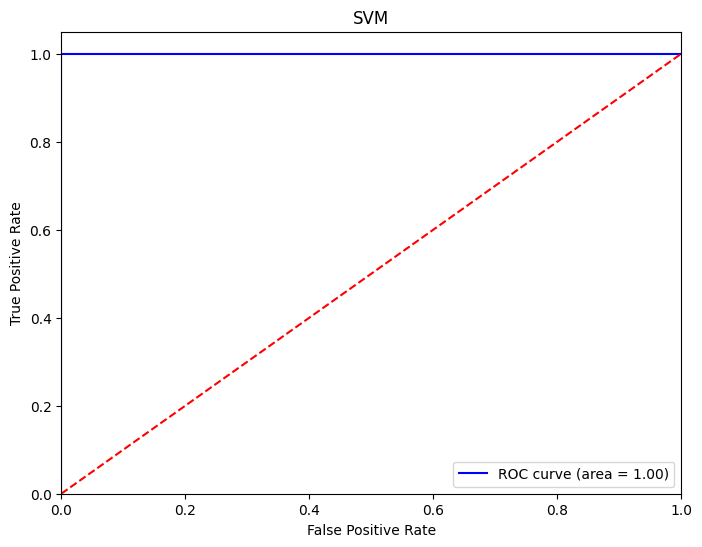

In [28]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM')
plt.legend(loc='lower right')
plt.show()

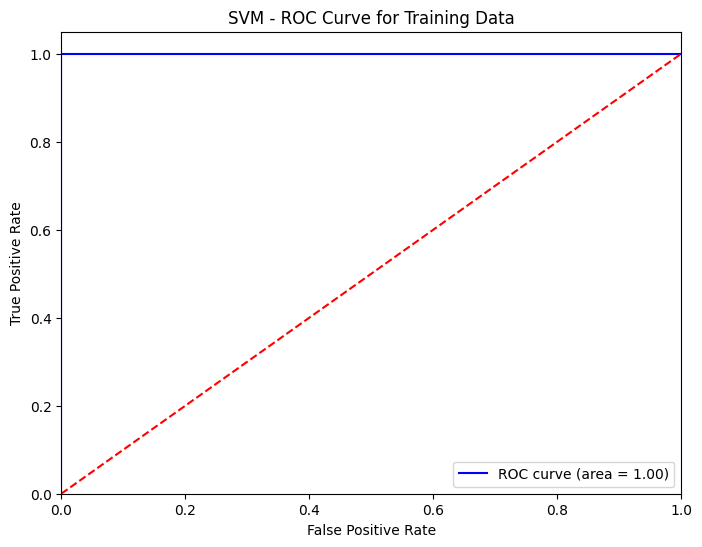

In [38]:
# Predict probabilities for the training data
y_train_proba = model_xgb.predict_proba(X_train)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)

# Calculate the area under the ROC curve (AUC) for training data
roc_auc_train = auc(fpr_train, tpr_train)

# Plot the ROC curve for training data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curve for Training Data')
plt.legend(loc='lower right')
plt.show()

# Miscellaneous:

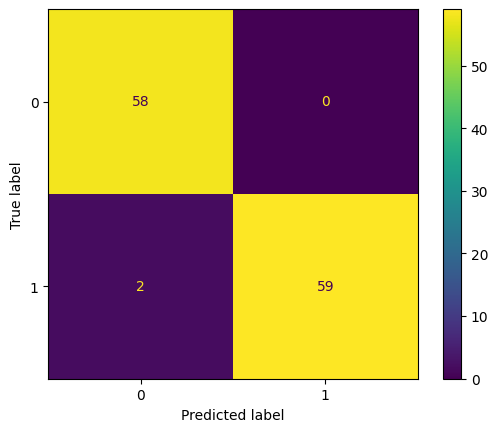

In [30]:
#######CONFUSION MATRIX ###########
from sklearn import metrics
y_test_pred_xgb = model_xgb.predict(X_test)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test)
cm_display.plot()
plt.show()

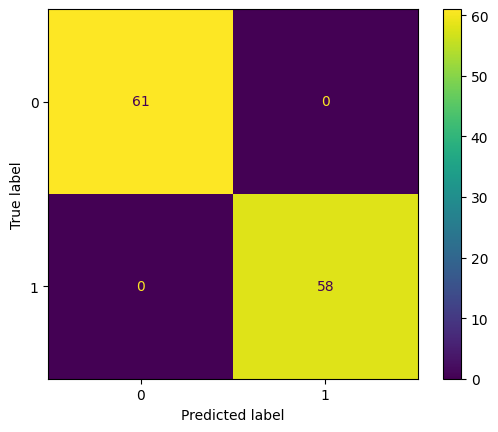

In [31]:
#######CONFUSION MATRIX ###########
y_train_pred_xgb = model_xgb.predict(X_train)
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train)
cm_display.plot()
plt.show()

In [32]:
total1=sum(sum(confusion_matrix_test))
#####from confusion matrix calculate accuracy
accuracy1=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.9831932773109243
Sensitivity :  1.0
Specificity :  0.9672131147540983


# Feature importance

In [33]:
# for important features:
important_feat = model_xgb.coef_[0]
#get indices of those important features
idx = important_feat.argsort(kind= "quicksort")
idx= idx[::-1][:50]

In [34]:
idx

array([140,  32,  84,  17, 169, 208,  29,  89,  83, 215, 113, 212, 170,
        85,  94, 103,  10,  75,  52,  49, 126, 228,  65,  62, 123,  66,
        74,  53,  87, 158, 200, 160,  57,  44,  86,  27,  61,  63, 150,
        56,   5,  33, 202,  88, 229,   6,   9,  97, 196,  90])

In [35]:
df1 = X.T

In [36]:
top_met = df1.iloc[idx]

In [37]:
top_met.index

Index(['hsa-miR-424-5p', 'hsa-miR-130b-3p', 'hsa-miR-21-5p', 'hsa-miR-1246',
       'hsa-miR-455-3p', 'hsa-miR-7-5p', 'hsa-miR-1290', 'hsa-miR-224-5p',
       'hsa-miR-21-3p', 'hsa-miR-96-5p', 'hsa-miR-3198', 'hsa-miR-93-5p',
       'hsa-miR-455-5p', 'hsa-miR-214-3p', 'hsa-miR-25-3p', 'hsa-miR-301a-3p',
       'hsa-miR-106b-5p', 'hsa-miR-199a-5p', 'hsa-miR-152', 'hsa-miR-151a-3p',
       'hsa-miR-3651', 'miRNABrightCorner30', 'hsa-miR-18a-5p',
       'hsa-miR-181b-5p', 'hsa-miR-34b-5p', 'hsa-miR-18b-5p',
       'hsa-miR-199a-3p', 'hsa-miR-155-5p', 'hsa-miR-22-5p', 'hsa-miR-4449',
       'hsa-miR-630', 'hsa-miR-4465', 'hsa-miR-16-2-3p', 'hsa-miR-146b-5p',
       'hsa-miR-22-3p', 'hsa-miR-128', 'hsa-miR-181a-5p', 'hsa-miR-185-5p',
       'hsa-miR-4306', 'hsa-miR-15b-5p', 'hsa-let-7d-5p', 'hsa-miR-132-3p',
       'hsa-miR-642a-3p', 'hsa-miR-223-3p', 'mr_1', 'hsa-let-7i-5p',
       'hsa-miR-103a-3p', 'hsa-miR-27a-3p', 'hsa-miR-574-5p',
       'hsa-miR-23a-3p'],
      dtype='object')